In [1]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

import nibabel as nib

from nilearn import plotting
from nilearn.masking import apply_mask,unmask

import importlib
import sub
importlib.reload(sub)

%matplotlib inline 


In [2]:
cwd = Path.cwd()
pcc_mask_img = nib.load(cwd / "ROI" / "PCC_mask.nii.gz")
pcc_mask = pcc_mask_img.get_fdata().astype(bool)
gm_mask_img = nib.load(cwd / "derivates" / "group_mask_gm_th50.nii.gz")
gm_mask = gm_mask_img.get_fdata().astype(bool)
sub01 = sub.Subject("sub_001")
img = nib.load(sub01.get_processed_run("hypo", "R1", gsr = False))
data = img.get_fdata()

data_gm = data[gm_mask]
mean = np.mean(data_gm.mean(axis= -1))
std = np.mean(data_gm.std(axis= -1))

mean, std

(np.float64(-4.662281807128883e-11), np.float64(0.4938993554109731))

In [3]:
cwd = Path.cwd()
pcc_mask_img = nib.load(cwd / "ROI" / "PCC_mask.nii.gz")
pcc_mask = pcc_mask_img.get_fdata().astype(bool)
gm_mask_img = nib.load(cwd / "derivates" / "group_mask_gm_th50.nii.gz")
gm_mask = gm_mask_img.get_fdata().astype(bool)

PERCENTILE_THRESH = 85  # Top 15% (100 - 15)
#PERCENTILE_THRESH = 80  # Top 20% (100 - 20)
K_CLUSTERS = 8
SAVE_PATH = cwd / "CAPs_results" / f"k{K_CLUSTERS}_PCCmask_percentile{PERCENTILE_THRESH}"
SAVE_PATH.mkdir(parents=True, exist_ok=True)

In [4]:

# #! ------ FRAME SELECTION AND CLUSTERING FUNCTIONS --------


# def frame_selection(subject_id, gsr : bool = False):
#     selected_frames_buffer = []
#     metadata_buffer = []
#     subj = sub.Subject(subject_id) 
    
#     phase_map = {
#         "hypo": {
#             "R1": "Normoglycemia",
#             "R2": "Glucose Lowering",
#             "R3": "Early Hypoglycemia",
#             "R4": "Late Hypoglycemia"
#         },
#         "hyper": {
#             "R1": "Isoglycemia",
#             "R2": "Glucose Raising",
#             "R3": "Early Hyperglycemia",
#             "R4": "Late Hyperglycemia"
#         }
#     }

#     for condition in ["hyper", "hypo"]:
#         for run_key in [f"R{i}" for i in range(1, 5)]:
            
#             # A. Load Data
#             func_path = subj.get_processed_run(condition, run_key, gsr=gsr)
#             try:
#                 func_img = nib.load(str(func_path))
#                 data = func_img.get_fdata()
#             except FileNotFoundError:
#                 print(f"Missing: {subject_id} {condition} {run_key}")
#                 continue

#             # B. Extract PCC Signal
#             pcc_signals = data[pcc_mask] 
#             pcc_tc = np.mean(pcc_signals, axis=0)
            
#             # C. Frame Selection (Percentile Based)
#             threshold_val = np.percentile(pcc_tc, PERCENTILE_THRESH)
#             active_indices = np.where(pcc_tc > threshold_val)[0]
            
#             # D. Extract Gray Matter Maps
#             gm_data = data[gm_mask]
#             gm_data_t = gm_data.T
#             active_maps = gm_data_t[active_indices, :]
            
#             # E. Store Data & Metadata
#             if active_maps.shape[0] > 0:
#                 selected_frames_buffer.append(active_maps)
                
#                 # Retrieve the biological phase name
#                 current_phase = phase_map[condition][run_key]
                
#                 for idx in active_indices:
#                     metadata_buffer.append({
#                         "Subject": subject_id,
#                         "Visit": condition,      # hypo/hyper
#                         "Run": run_key,          # (R1-R4)
#                         "Phase": current_phase,  # late hypoglycemia...
#                         "Group": subj.group,     # diabetes vs control
#                         "Sex": subj.sex,
#                         "TR_Index": idx
#                     })
                    
#     return selected_frames_buffer, metadata_buffer

def frame_selection(subject_id, gsr: bool = False, temporal_z_scoring: bool = True):
    selected_frames_buffer = []
    metadata_buffer = []
    subj = sub.Subject(subject_id) 
    
    phase_map = {
        "hypo": {
            "R1": "Normoglycemia",
            "R2": "Glucose Lowering",
            "R3": "Early Hypoglycemia",
            "R4": "Late Hypoglycemia"
        },
        "hyper": {
            "R1": "Isoglycemia",
            "R2": "Glucose Raising",
            "R3": "Early Hyperglycemia",
            "R4": "Late Hyperglycemia"
        }
    }

    for condition in ["hyper", "hypo"]:
        for run_key in [f"R{i}" for i in range(1, 5)]:
            
            # A. Load Data
            func_path = subj.get_processed_run(condition, run_key, gsr=gsr)
            try:
                func_img = nib.load(str(func_path))
                data = func_img.get_fdata()
            except FileNotFoundError:
                print(f"Missing: {subject_id} {condition} {run_key}")
                continue

            # B. Extract PCC Signal (Seed) for Thresholding
            # We extract this from raw data to find the indices
            pcc_signals = data[pcc_mask] 
            pcc_tc = np.mean(pcc_signals, axis=0)
            
            # C. Frame Selection (Percentile Based)
            threshold_val = np.percentile(pcc_tc, PERCENTILE_THRESH)
            active_indices = np.where(pcc_tc > threshold_val)[0]
            
            # D. Extract Gray Matter Maps
            # Shape is (X, Y, Z, Time) -> Masking -> (N_voxels_GM, Time)
            gm_data = data[gm_mask]

            # --- NEW BLOCK: TEMPORAL Z-SCORING ---
            if temporal_z_scoring:
                # Calculate mean and std along the TIME axis (axis=1)
                # keepdims=True keeps shape (N_voxels, 1) for broadcasting
                voxel_means = gm_data.mean(axis=1, keepdims=True)
                voxel_stds = gm_data.std(axis=1, keepdims=True)
                
                # Safety check: avoid division by zero for constant voxels
                voxel_stds[voxel_stds == 0] = 1.0
                
                # Apply Z-score: (X - Mean) / Std
                gm_data = (gm_data - voxel_means) / voxel_stds
            # -------------------------------------

            # Transpose to (Time, N_voxels) for extraction
            gm_data_t = gm_data.T
            active_maps = gm_data_t[active_indices, :]
            
            # E. Store Data & Metadata
            if active_maps.shape[0] > 0:
                selected_frames_buffer.append(active_maps)
                
                # Retrieve the biological phase name
                current_phase = phase_map[condition][run_key]
                
                for idx in active_indices:
                    metadata_buffer.append({
                        "Subject": subject_id,
                        "Visit": condition,      # hypo/hyper
                        "Run": run_key,          # (R1-R4)
                        "Phase": current_phase,  # late hypoglycemia...
                        "Group": subj.group,     # diabetes vs control
                        "Sex": subj.sex,
                        "TR_Index": idx
                    })
                    
    return selected_frames_buffer, metadata_buffer


def run_clustering(frames_buffer, k=K_CLUSTERS, random_state=42):
    print(f"--- Running Clustering (k={k}) ---")
    
    # 1. Stack
    X_raw = np.vstack(frames_buffer)
    print(f"Data shape: {X_raw.shape}")
    X_centered = X_raw - X_raw.mean(axis=1, keepdims=True)
    
    # Step B: L2 Normalization

    X_norm = normalize(X_centered, axis=1, norm='l2')

    
    # 3. K-Means
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X_norm)
    
    # Return X_raw (not centered) for map reconstruction
    return labels, X_raw

In [5]:

#! ------ EXTRACTION LOOP --------

all_subjects_list = sorted(sub.get_full_subject_list().keys())

master_frames_buffer = []   #list of arrays
master_metadata_buffer = [] #list of dicts

print(f"Starting extraction for {len(all_subjects_list)} subjects...")

for sub_id in tqdm(all_subjects_list, desc="Subjects", unit="sub"):
    
    sub_frames, sub_meta = frame_selection(sub_id, gsr=False, temporal_z_scoring=True)
    
    if sub_frames:
        master_frames_buffer.extend(sub_frames)
        master_metadata_buffer.extend(sub_meta)

Starting extraction for 17 subjects...


Subjects: 100%|██████████| 17/17 [06:08<00:00, 21.65s/sub]


In [6]:

# !------ CLUSTERING RUN --------
labels, X_raw = run_clustering(master_frames_buffer, k=K_CLUSTERS)

df_meta = pd.DataFrame(master_metadata_buffer)


assert len(df_meta) == len(labels), "Length mismatch between Metadata and Labels!"

# Add the cluster label to each frame

df_meta['Cluster_Label'] = labels

print("Merged Labels. DataFrame Head:")
print(df_meta.head())

--- Running Clustering (k=8) ---
Data shape: (4080, 147374)
Merged Labels. DataFrame Head:
   Subject  Visit Run        Phase    Group Sex  TR_Index  Cluster_Label
0  sub_001  hyper  R1  Isoglycemia  control   F         6              0
1  sub_001  hyper  R1  Isoglycemia  control   F         7              0
2  sub_001  hyper  R1  Isoglycemia  control   F         9              0
3  sub_001  hyper  R1  Isoglycemia  control   F        10              0
4  sub_001  hyper  R1  Isoglycemia  control   F        11              3


In [7]:
# # --- Inspection of Frame Counts ---

# # 1. Total Number of Frames
# total_frames = len(df_meta)
# print(f"\n--- Frame Count Summary ---")
# print(f"Total Selected Frames (All Subjects/Phases): {total_frames}")

# # 2. Number of Frames per Subject
# # This counts how many rows exist for each unique Subject ID
# frames_per_subject = df_meta['Subject'].value_counts().sort_index()

# print("\n--- Frames per Subject ---")
# print(frames_per_subject)

# # 3. Descriptive Stats (To check for imbalance)
# print("\n--- Statistics ---")
# print(f"Average frames per subject: {frames_per_subject.mean():.1f}")
# print(f"Min frames: {frames_per_subject.min()}")
# print(f"Max frames: {frames_per_subject.max()}")

Reconstructing and plotting CAP maps...


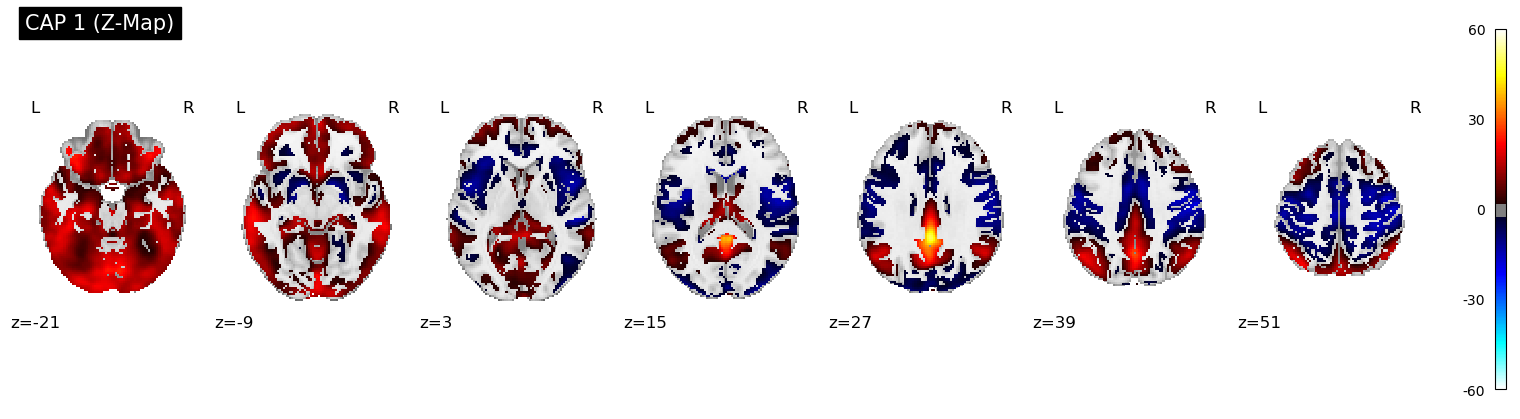

Saved and displayed CAP 1


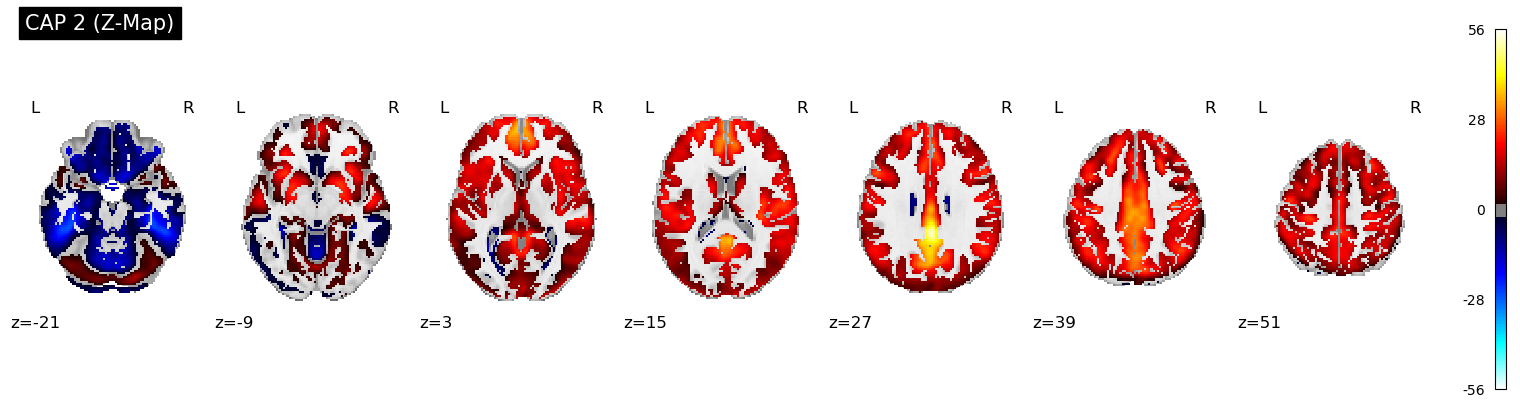

Saved and displayed CAP 2


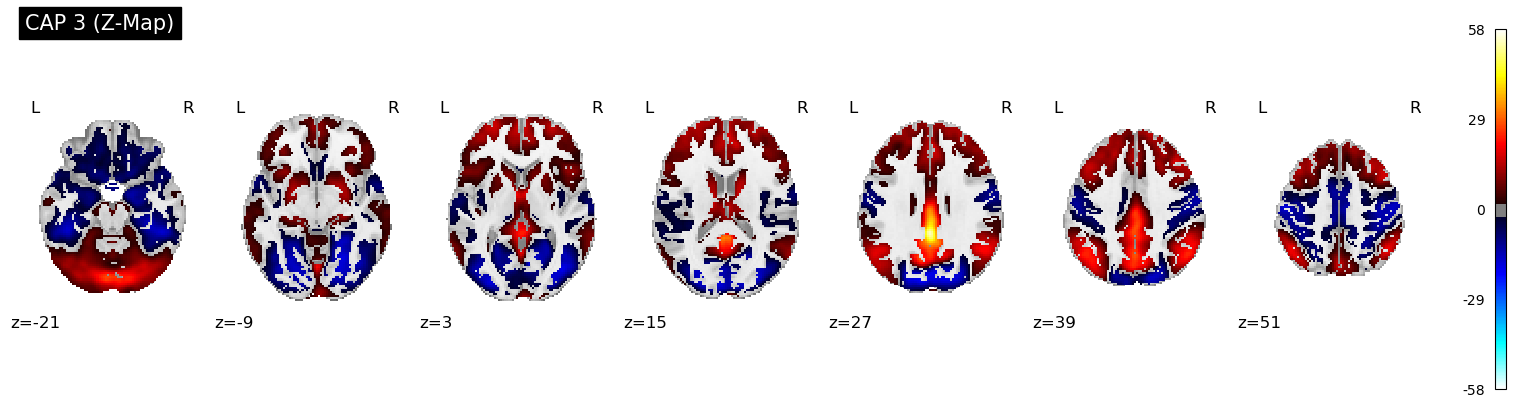

Saved and displayed CAP 3


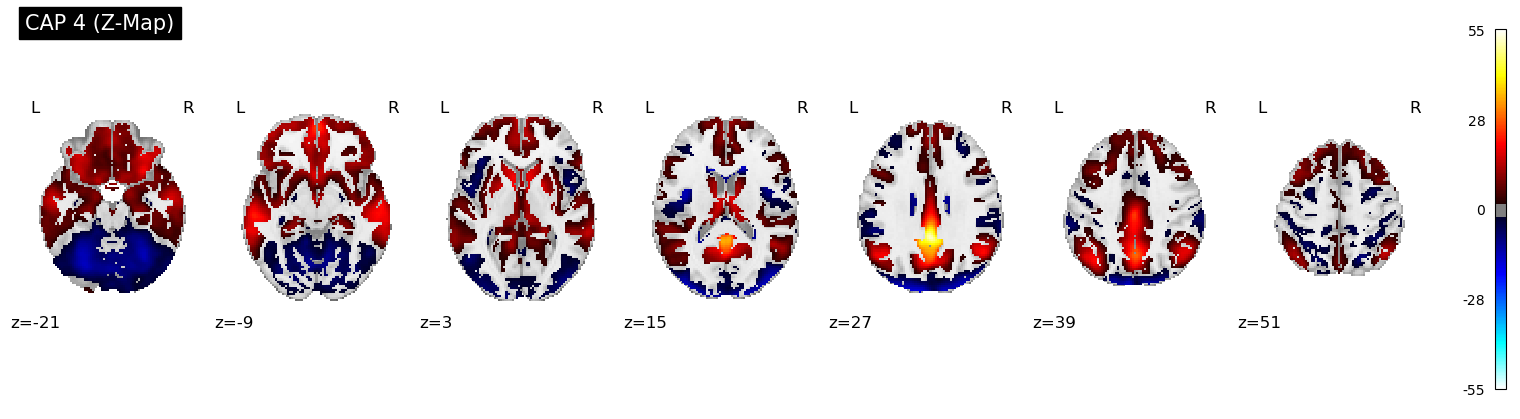

Saved and displayed CAP 4


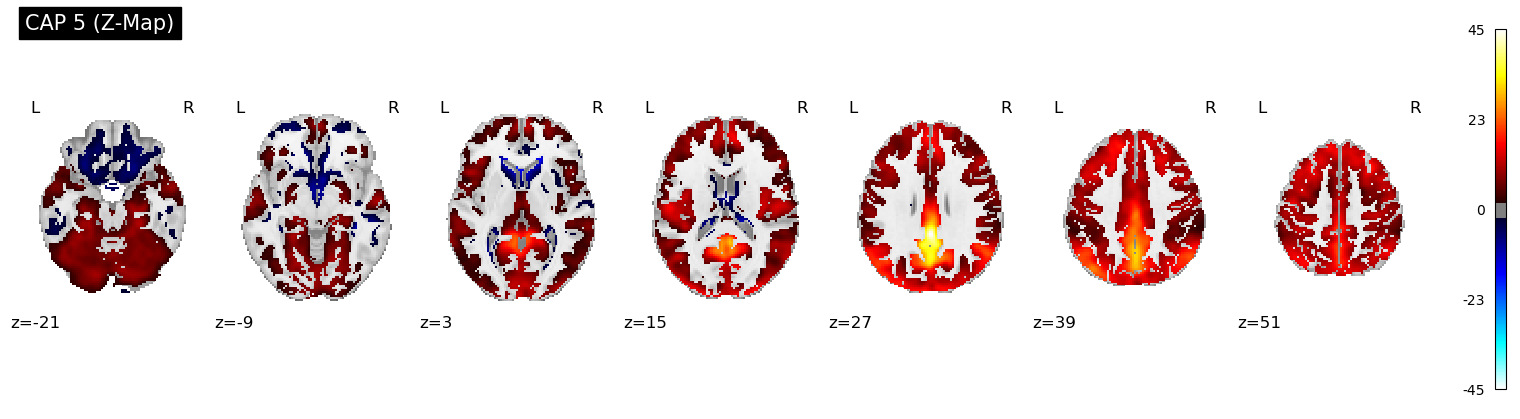

Saved and displayed CAP 5


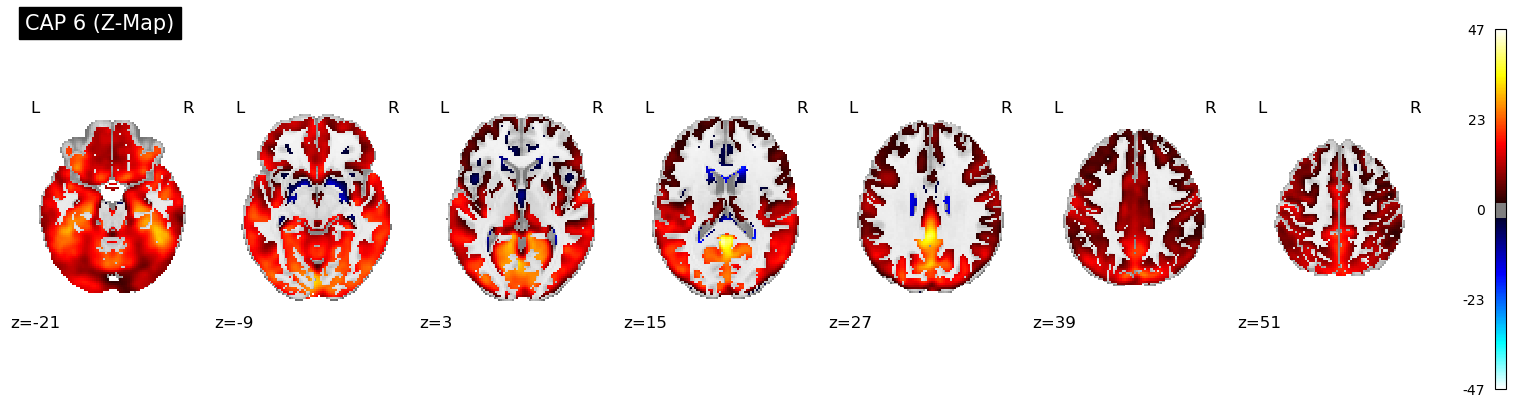

Saved and displayed CAP 6


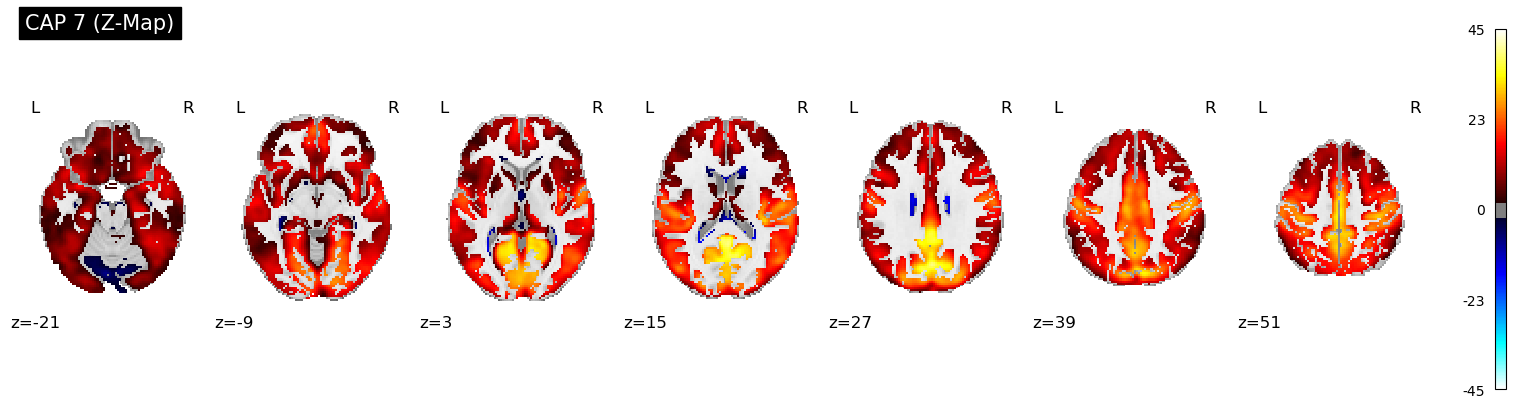

Saved and displayed CAP 7


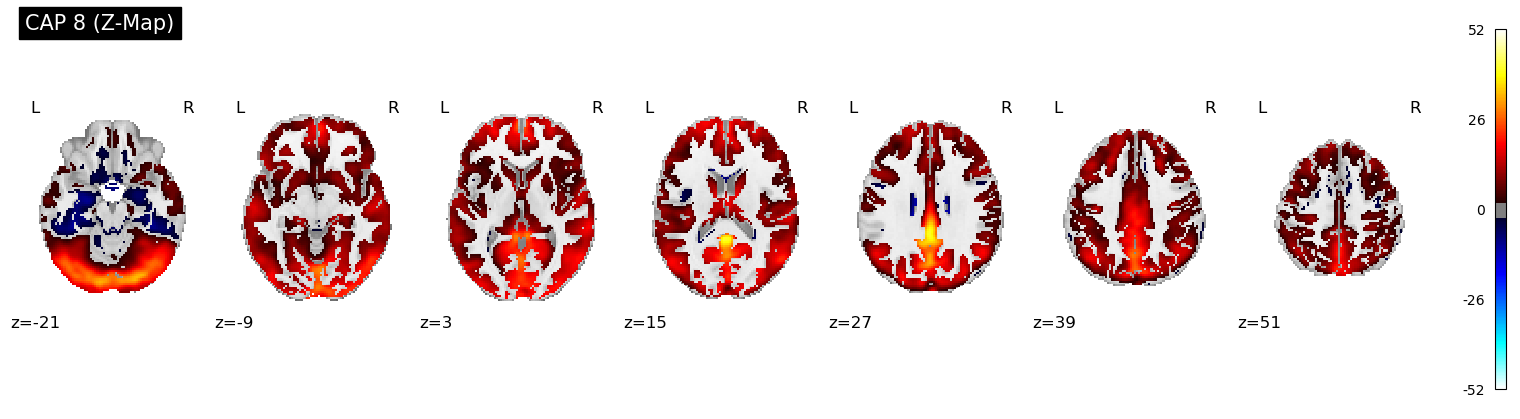

Saved and displayed CAP 8


In [13]:


def reconstruct_and_plot_caps(X_raw, labels, gm_mask_img, output_dir = SAVE_PATH / "cap_maps", k=K_CLUSTERS):
    """
    Computes Centroids -> Z-score Maps -> Saves NIfTI -> Generates Plots -> Shows in Notebook
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    #cut_coords = [-25, -10, 5, 20, 35, 50, 65]
    cut_coords = [-21, -9, 3, 15, 27, 39, 51]
    
    print("Reconstructing and plotting CAP maps...")
    
    for i in range(k):
        # 1. Get all frames belonging to this cluster
        cluster_frames = X_raw[labels == i]
        
        # 2. Compute Z-Map
        mean_map = np.mean(cluster_frames, axis=0)
        std_map = np.std(cluster_frames, axis=0)
        n = len(cluster_frames)
        se_map = std_map / np.sqrt(n)
        z_map_data = mean_map / (se_map + 1e-12)
        
        # 3. Unmask
        cap_img = unmask(z_map_data, gm_mask_img)
        
        # 4. Save NIfTI
        nifti_path = output_dir / f"CAP_{i+1}_k{k}_Zmap.nii.gz"
        cap_img.to_filename(nifti_path)
        
        # 5. Generate Plot
        fig = plt.figure(figsize=(15, 4))
        plotting.plot_stat_map(
            cap_img, 
            display_mode='z',           
            cut_coords=cut_coords,      
            threshold=2.3,              
            cmap='cold_hot',            
            colorbar=True,
            title=f"CAP {i+1} (Z-Map)",
            figure=fig
        )
        
        # Save to disk
        plot_path = output_dir / f"CAP_{i+1}_Visualization.png"
        output_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        
        # --- NEW: Show in Notebook ---
        plotting.show()  # This renders the figure in the cell output
        
        # Close to free memory after showing
        plt.close(fig) 
        print(f"Saved and displayed CAP {i+1}")


reconstruct_and_plot_caps(X_raw, labels, gm_mask_img)

In [9]:



phase_order = [
    "Normoglycemia", "Glucose Lowering", "Early Hypoglycemia", "Late Hypoglycemia",
    "Isoglycemia", "Glucose Raising", "Early Hyperglycemia", "Late Hyperglycemia"
]

def compute_phase_stats(df_meta, k=K_CLUSTERS, output_dir=SAVE_PATH):
  
    stats_list = []
    

    grouped = df_meta.groupby(['Subject', 'Group', 'Visit', 'Phase'])
    
    for (sub, group, visit, phase), group_df in grouped:
        total_frames = len(group_df)
        
        if total_frames == 0: continue # Skip empty if any
        
        for i in range(k):
            # Count how many frames belonged to CAP i
            n_frames = len(group_df[group_df['Cluster_Label'] == i])
            
            # Calculate Fraction 
            fraction = n_frames / total_frames
            
            stats_list.append({
                'Subject': sub,
                'Group': group,      # Diabetes vs Control
                'Visit': visit,      # Hypo vs Hyper
                'Phase': phase,      # e.g., 'Late Hypoglycemia'
                'CAP_ID': i + 1,     # 1-based index for readability
                'Occurrence': fraction
            })
            
    df_stats = pd.DataFrame(stats_list)
    

    df_stats['Phase'] = pd.Categorical(df_stats['Phase'], categories=phase_order, ordered=True)
    save_to = SAVE_PATH / "CAPs_Occurrence_Rates.csv"
    df_stats.to_csv(save_to, index=False)
    
    return df_stats


df_stats = compute_phase_stats(df_meta, k=K_CLUSTERS, output_dir=SAVE_PATH)
df_stats.head()

,Subject,Group,Visit,Phase,CAP_ID,Occurrence
0,sub_001,control,hyper,Early Hyperglycemia,1,0.066667
1,sub_001,control,hyper,Early Hyperglycemia,2,0.200000
2,sub_001,control,hyper,Early Hyperglycemia,3,0.200000
3,sub_001,control,hyper,Early Hyperglycemia,4,0.133333
4,sub_001,control,hyper,Early Hyperglycemia,5,0.100000


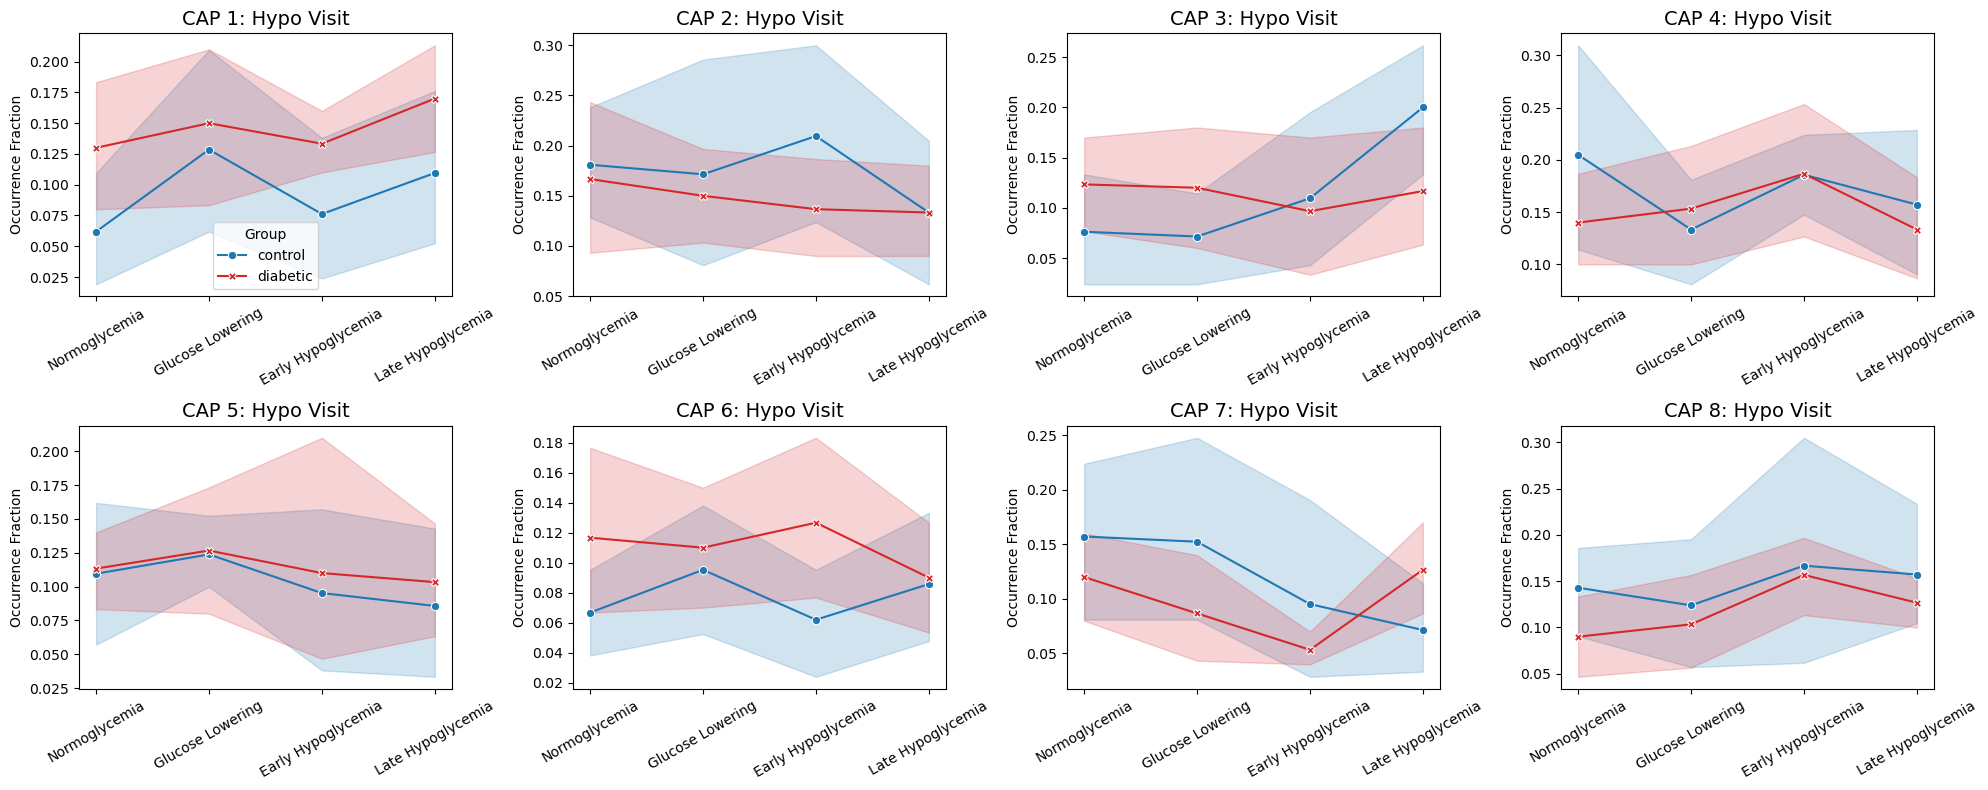

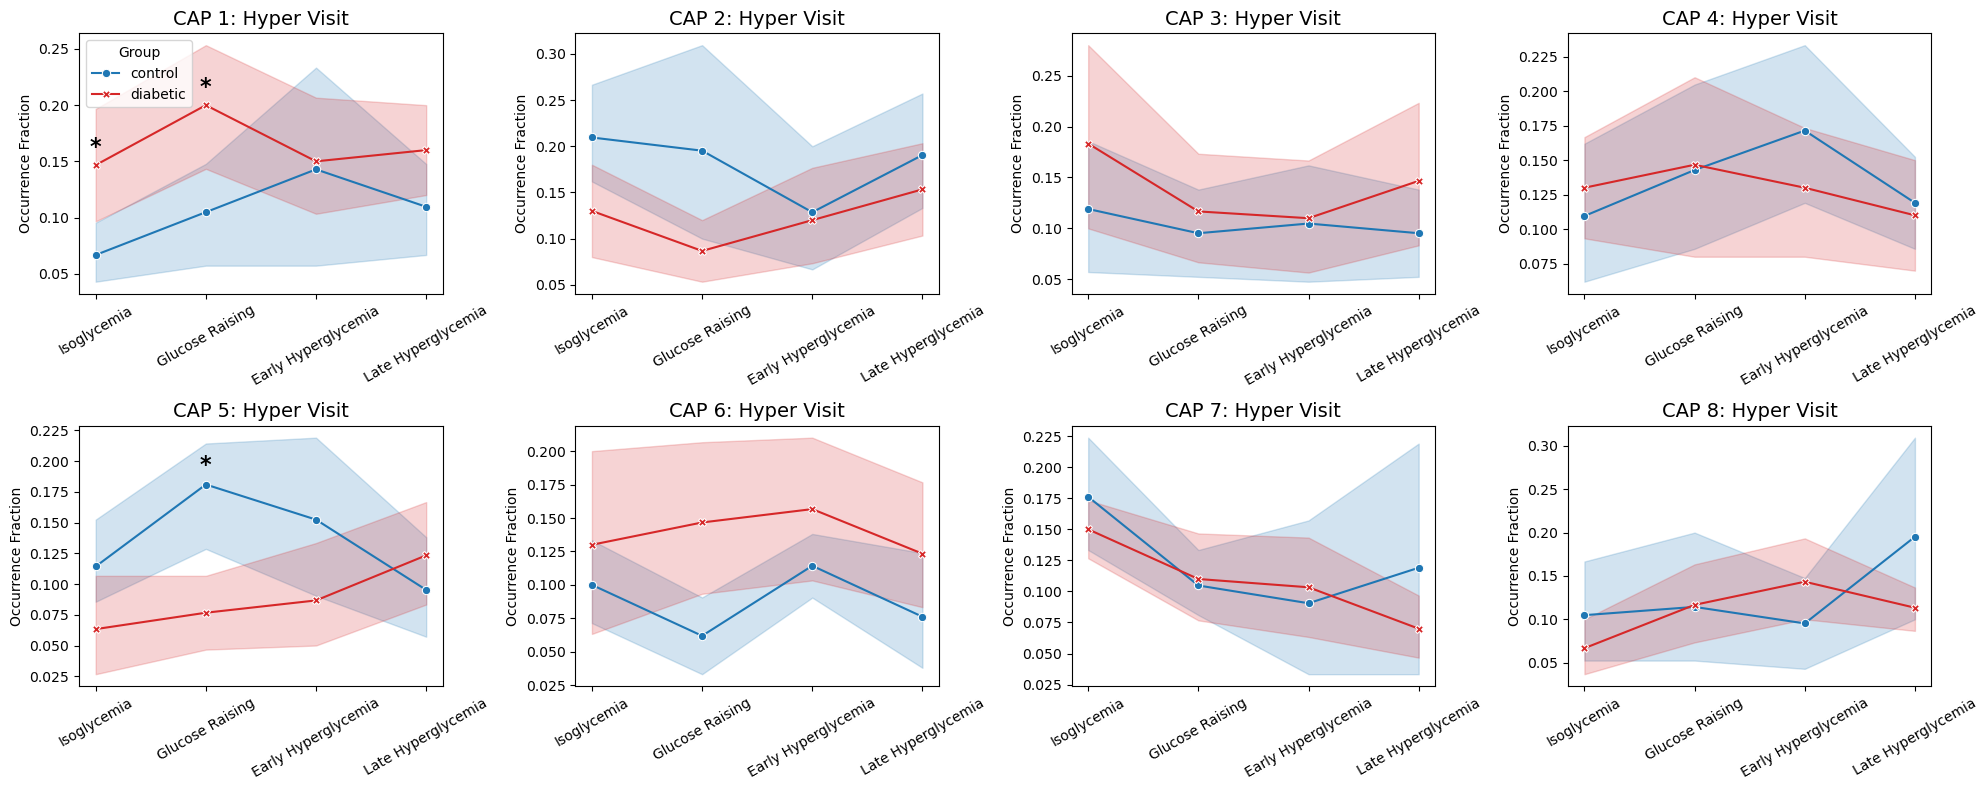

,Visit,CAP,Phase,p_val,Sig
0,hyper,1,Isoglycemia,0.041508,*
1,hyper,1,Glucose Raising,0.048980,*
2,hyper,1,Early Hyperglycemia,0.655364,
3,hyper,1,Late Hyperglycemia,0.135575,
4,hyper,2,Isoglycemia,0.139049,
5,hyper,2,Glucose Raising,0.195846,
6,hyper,2,Early Hyperglycemia,0.921536,
7,hyper,2,Late Hyperglycemia,0.490781,
8,hyper,3,Isoglycemia,0.522531,
9,hyper,3,Glucose Raising,1.000000,


In [10]:


def analyze_and_plot_trajectories(df_stats, visit_type='hypo', k=K_CLUSTERS, output_dir=SAVE_PATH):
    """
    Plots trajectories and runs stats for a specific visit type ('hypo' or 'hyper').
    """

    if visit_type == 'hypo':
        phases_of_interest = ["Normoglycemia", "Glucose Lowering", "Early Hypoglycemia", "Late Hypoglycemia"]
        title_suffix = "Hypo Visit"
    elif visit_type == 'hyper':
        phases_of_interest = ["Isoglycemia", "Glucose Raising", "Early Hyperglycemia", "Late Hyperglycemia"]
        title_suffix = "Hyper Visit"
    else:
        raise ValueError("visit_type must be 'hypo' or 'hyper'")

   
    df_visit = df_stats[df_stats['Phase'].isin(phases_of_interest)].copy()
    
    n_cols = 4
    n_rows = math.ceil(k / n_cols)
    

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    
    stats_results = []
    
    for i in range(k):
        cap_id = i + 1
        ax = axes[i]
        

        sns.lineplot(
            data=df_visit[df_visit['CAP_ID'] == cap_id],
            x='Phase', y='Occurrence',
            hue='Group', style='Group',
            markers=True, dashes=False, err_style='band', 
            palette={'control': 'tab:blue', 'diabetic': 'tab:red'},
            ax=ax
        )
        
        ax.set_title(f"CAP {cap_id}: {title_suffix}", fontsize=14)
        ax.set_ylabel("Occurrence Fraction")
        ax.set_xlabel("")
        ax.tick_params(axis='x', rotation=30)
        
        # Legend management
        if i > 0: 
            if ax.get_legend() is not None:
                ax.get_legend().remove()
        
        #! mannwhitneyu testing
        for phase in phases_of_interest:
            subset = df_visit[(df_visit['CAP_ID'] == cap_id) & (df_visit['Phase'] == phase)]
            
            vals_ctrl = subset[subset['Group'] == 'control']['Occurrence']
            vals_t2d = subset[subset['Group'] == 'diabetic']['Occurrence']
            
            # Mann-Whitney U Test
            if len(vals_ctrl) > 1 and len(vals_t2d) > 1:
                stat, p = stats.mannwhitneyu(vals_ctrl, vals_t2d, alternative='two-sided')
                
                stats_results.append({
                    'Visit': visit_type,
                    'CAP': cap_id, 
                    'Phase': phase, 
                    'p_val': p, 
                    'Sig': '*' if p < 0.05 else ''
                })
                
                # Annotate Plot if Significant
                if p < 0.05:
                    # Old line (jumps for outliers)
                    max_y = subset['Occurrence'].max()
                    max_y = subset.groupby('Group')['Occurrence'].mean().max() 
                    ax.text(phase, max_y + 0.01, "*", ha='center', color='black', fontsize=16, fontweight='bold')

    plt.tight_layout()
    
    # Save Plot
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        save_path = output_dir / f"CAPs_{visit_type.capitalize()}_Trajectories.png"
        plt.savefig(save_path, dpi=300)
        
    plt.show()
    
    # Return Stats Table
    return pd.DataFrame(stats_results)

analyze_and_plot_trajectories(df_stats, k=K_CLUSTERS, visit_type="hypo", output_dir=SAVE_PATH )
analyze_and_plot_trajectories(df_stats, k=K_CLUSTERS, visit_type="hyper", output_dir=SAVE_PATH)

--- Analyse Globale (Effet Principal du Groupe) ---


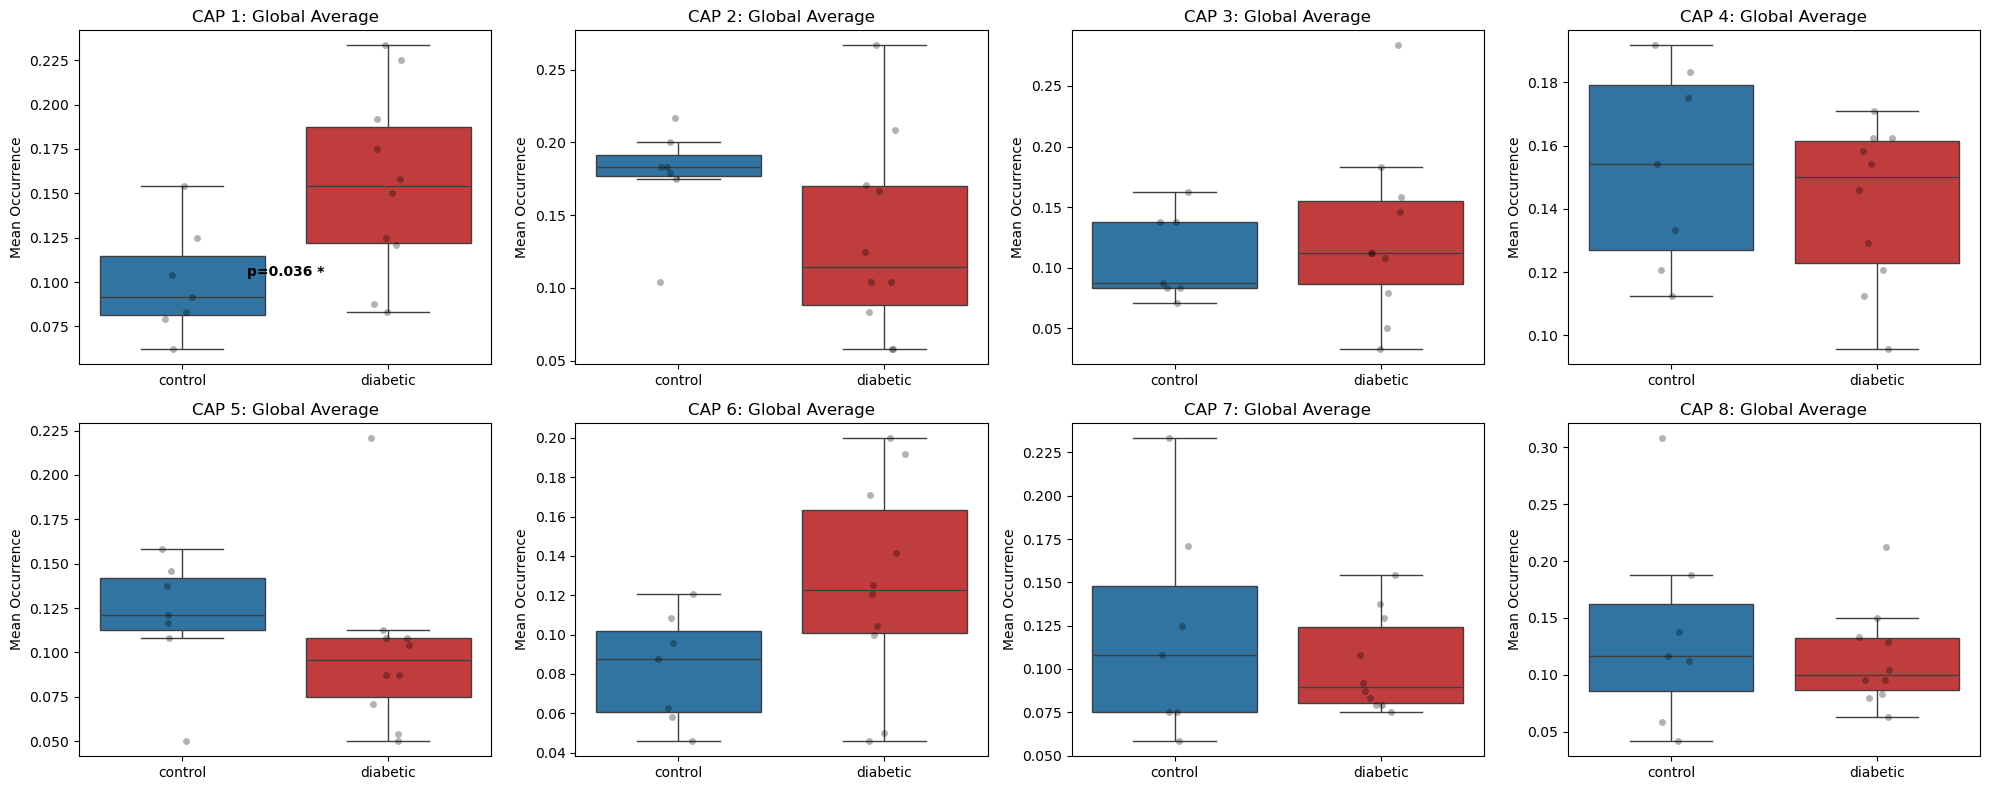

   CAP     p_val Sig
0    1  0.035662   *


In [11]:

def analyze_global_group_differences(df_stats, k=K_CLUSTERS):
    """
    Compare les groupes Control vs Diabetic en moyennant toutes les phases.
    Teste l'Effet Principal du Groupe.
    """
    print("--- Analyse Globale (Effet Principal du Groupe) ---")
    
    # 1. Agréger les données par SUJET (Moyenne de toutes les phases)
    # On ignore la colonne 'Phase' et 'Visit' pour avoir une seule valeur par sujet par CAP
    df_global = df_stats.groupby(['Subject', 'Group', 'CAP_ID'])['Occurrence'].mean().reset_index()
    
    # Préparer la figure
    n_cols = 4
    n_rows = (k + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    
    results = []
    
    for i in range(k):
        cap_id = i + 1
        ax = axes[i]
        
        # Données pour ce CAP
        subset = df_global[df_global['CAP_ID'] == cap_id]
        
        # --- A. Visualisation (Boxplot) ---
        # Le Boxplot est meilleur que le Lineplot pour les comparaisons globales
        sns.boxplot(
            data=subset, x='Group', y='Occurrence',
            hue='Group', palette={'control': 'tab:blue', 'diabetic': 'tab:red'},
            ax=ax, showfliers=False # Cache les outliers extrêmes pour la lisibilité
        )
        # Ajout des points individuels (strip plot) pour voir la distribution réelle
        sns.stripplot(
            data=subset, x='Group', y='Occurrence',
            color='black', alpha=0.3, jitter=True, ax=ax
        )
        
        ax.set_title(f"CAP {cap_id}: Global Average")
        ax.set_ylabel("Mean Occurrence")
        ax.set_xlabel("")
        
        # --- B. Stats (Mann-Whitney U sur les moyennes sujets) ---
        ctrl_vals = subset[subset['Group'] == 'control']['Occurrence']
        diab_vals = subset[subset['Group'] == 'diabetic']['Occurrence']
        
        if len(ctrl_vals) > 0 and len(diab_vals) > 0:
            stat, p = stats.mannwhitneyu(ctrl_vals, diab_vals, alternative='two-sided')
            
            # Stocker le résultat
            results.append({'CAP': cap_id, 'p_val': p, 'Sig': '*' if p < 0.05 else ''})
            
            # Afficher l'étoile si significatif
            if p < 0.05:
                # Positionner l'étoile un peu au-dessus de la valeur max
                y_max = subset['Occurrence'].max()
                ax.text(0.5, y_max + 0.02, f"p={p:.3f} *", 
                        ha='center', va='bottom', color='black', fontweight='bold', transform=ax.get_xaxis_transform())

    # Cacher les subplots vides
    for j in range(k, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(results)

# Lancer l'analyse
df_global_results = analyze_global_group_differences(df_stats, k=K_CLUSTERS)
print(df_global_results[df_global_results['p_val'] < 0.05])

In [12]:
def compute_consistency(X_raw, labels, k=K_CLUSTERS):
    consistency_scores = []
    
    # Pre-compute centroids (Mean maps)
    centroids = []
    for i in range(k):
        cluster_data = X_raw[labels == i]
        centroid = np.mean(cluster_data, axis=0)
        # Normalize centroid for correlation calculation
        centroid_norm = centroid - np.mean(centroid)
        centroid_norm = centroid_norm / np.linalg.norm(centroid_norm)
        centroids.append(centroid_norm)
    
    # Calculate average correlation for each cluster
    for i in range(k):
        cluster_data = X_raw[labels == i]
        if len(cluster_data) == 0:
            consistency_scores.append(0)
            continue
            
        # Center and Normalize individual frames
        frames_centered = cluster_data - np.mean(cluster_data, axis=1, keepdims=True)
        frames_norm = frames_centered / np.linalg.norm(frames_centered, axis=1, keepdims=True)
        
        # Dot product with centroid = Correlation
        correlations = np.dot(frames_norm, centroids[i])
        avg_consistency = np.mean(correlations)
        
        consistency_scores.append(avg_consistency)
        
    return np.array(consistency_scores)

compute_consistency(X_raw, labels, k=K_CLUSTERS)

array([0.37837603, 0.44469405, 0.37756143, 0.29586572, 0.27788119,
       0.32411476, 0.38992588, 0.31905711])